In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

/tmp/ipykernel_2061466/1167711580.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
datasets = os.walk('./test_results').__next__()[1]

df = pd.DataFrame(columns=['dataset', 'exp_type', 'num_labeled', 'test_loss', 'test_acc', 'test_ece'])
for dataset in datasets:
    exp_types = os.walk('./test_results/' + dataset).__next__()[1]
    for exp_type in exp_types:
        metrics = pd.read_csv(f'./test_results/{dataset}/{exp_type}/test_metrics.csv')
        for num_labeled in metrics['num_labeled']:
            test_loss = metrics[metrics['num_labeled'] == num_labeled]['test_loss'].values[0]
            test_acc = metrics[metrics['num_labeled'] == num_labeled]['test_acc'].values[0]
            test_ece = metrics[metrics['num_labeled'] == num_labeled]['test_ece'].values[0]

            df.loc[len(df)] = {'dataset': dataset, 'exp_type': exp_type, 'num_labeled': num_labeled, 'test_loss': test_loss, 'test_acc': test_acc, 'test_ece': test_ece}

In [7]:
agg_df = pd.DataFrame(columns=['dataset', 'exp_type', 'min_ece', 'max_acc', 'final_ece', 'final_acc'])

for dataset in ['organsmnist']:
    exp_types = os.walk('./test_results/' + dataset).__next__()[1]
    for exp_type in ['active-softmax']:
        ece = df[(df['dataset'] == dataset) & (df['exp_type'] == exp_type)]['test_ece'].values
        acc = df[(df['dataset'] == dataset) & (df['exp_type'] == exp_type)]['test_acc'].values
        
        try:
            min_ece = np.min(ece)
            max_acc = np.max(acc)
            final_ece = ece[-1]
            final_acc = acc[-1]
            agg_df.loc[len(agg_df)] = {'dataset': dataset, 'exp_type': exp_type, 'min_ece': min_ece*100, 'max_acc': max_acc*100, 'final_ece': final_ece*100, 'final_acc': final_acc*100}
        except ValueError:
            continue                                

,dataset,exp_type,min_ece,max_acc,final_ece,final_acc
0,organsmnist,active-softmax,14.284838,77.262944,14.315451,77.262944


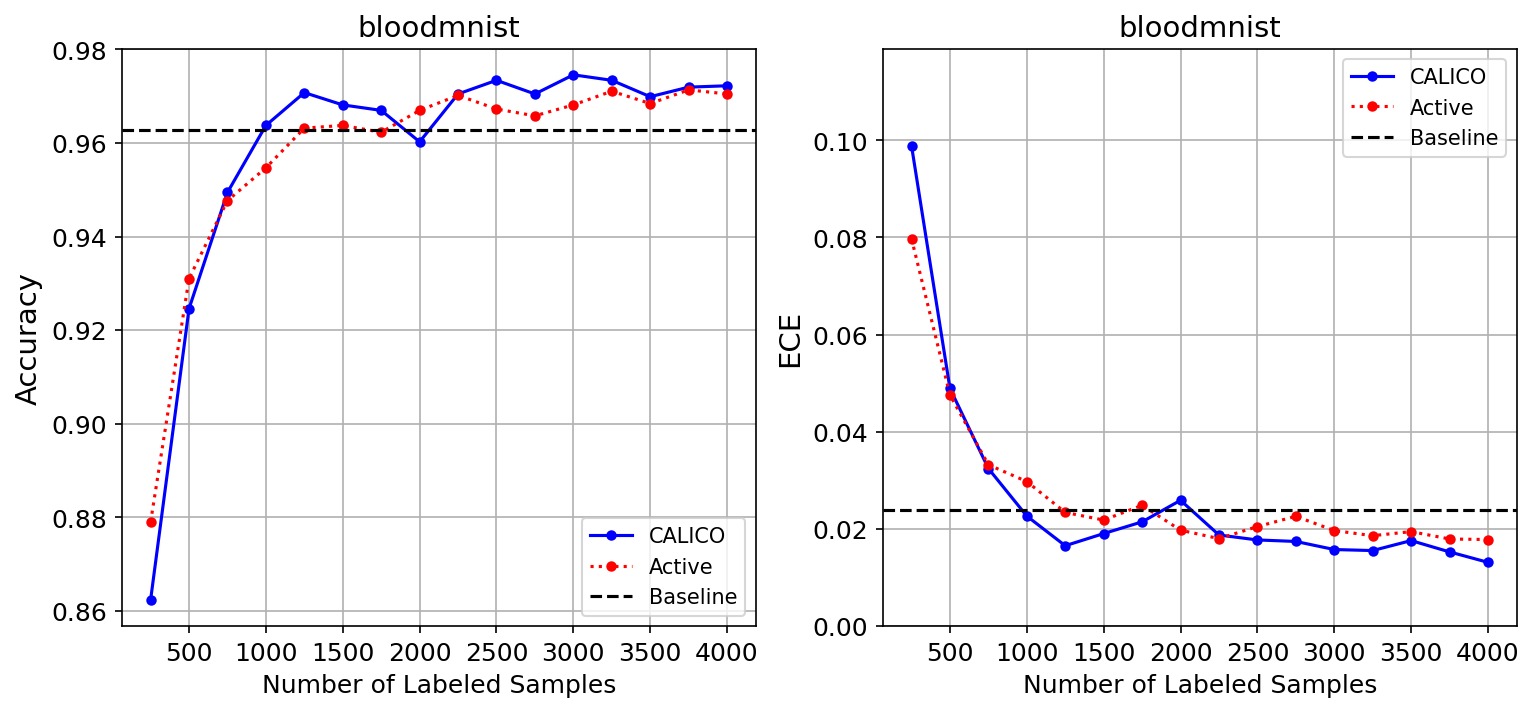

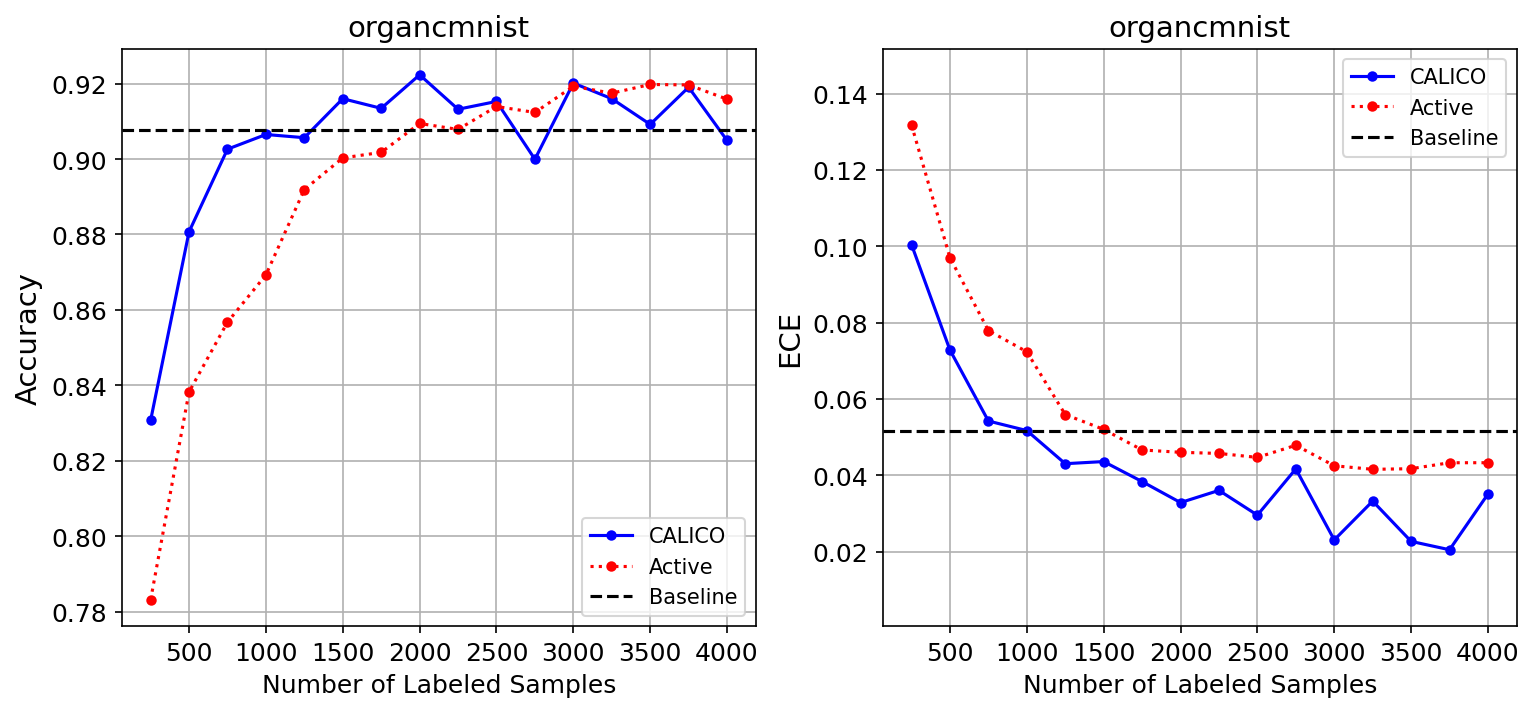

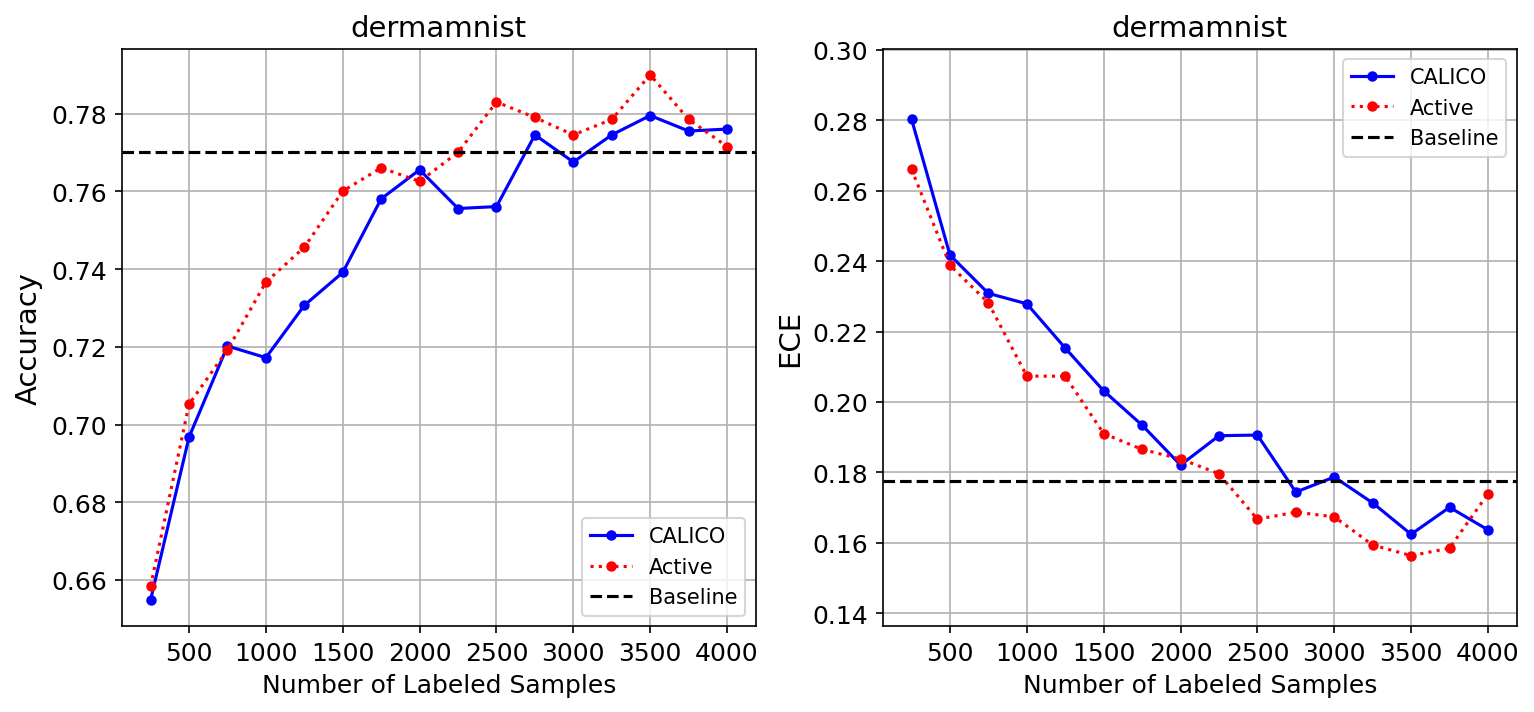

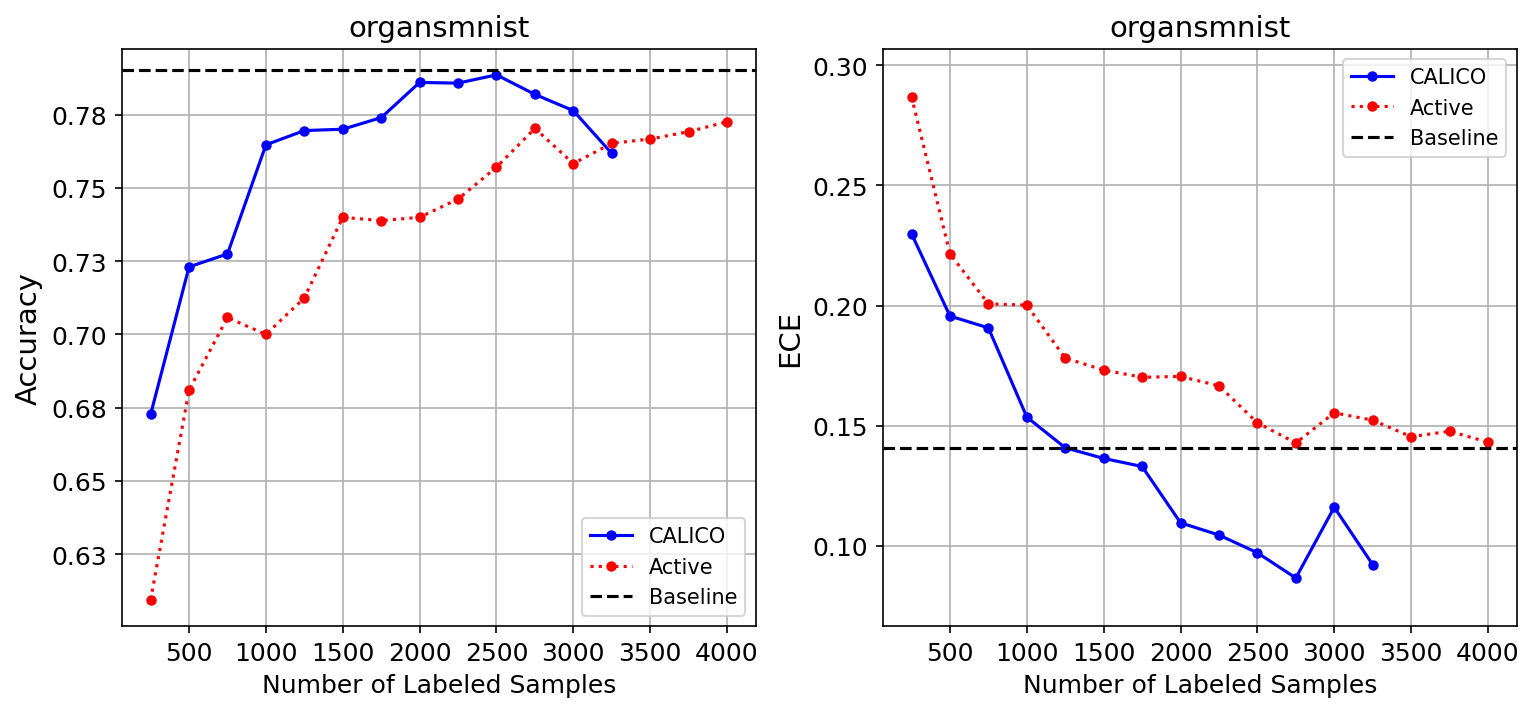

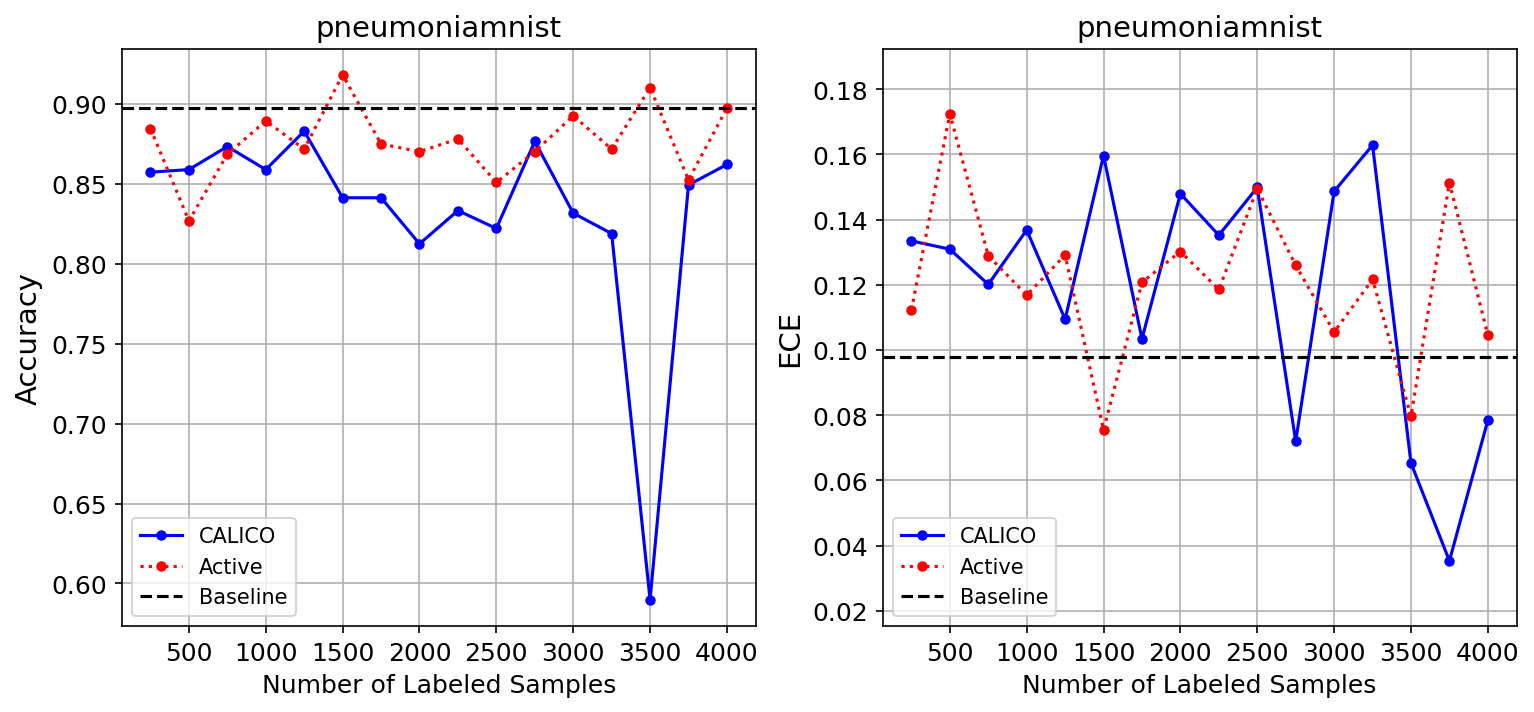

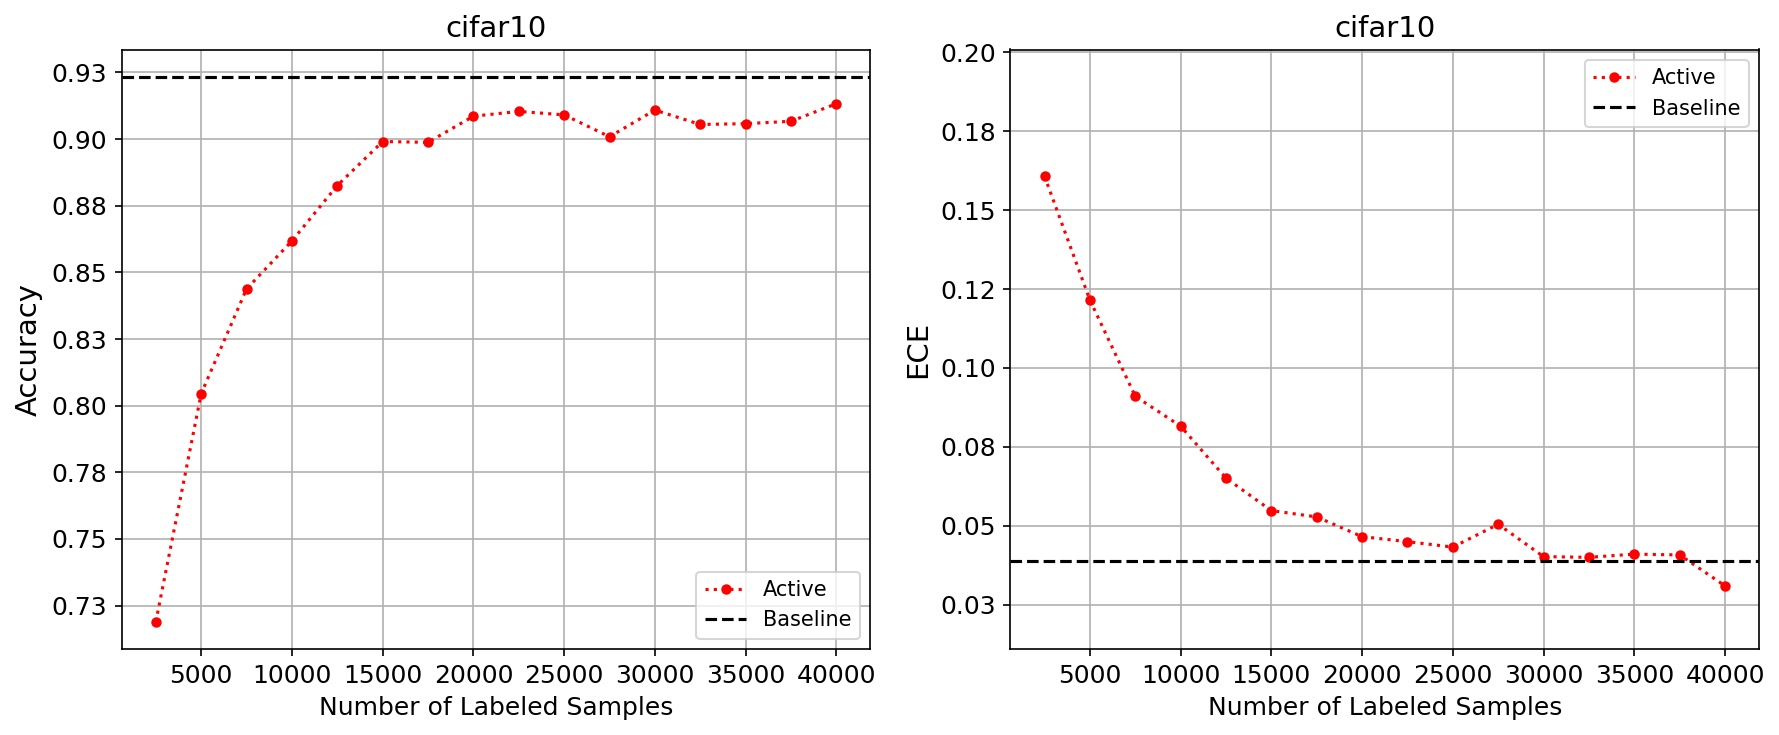

In [5]:
datasets = df['dataset'].unique()

# Iterate over the datasets
for i, dataset in enumerate(datasets):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=150)
    df_filtered = df[df['dataset'] == dataset]

    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(10))

    ax1.yaxis.set_major_formatter(FuncFormatter('{:.2f}'.format))
    ax2.yaxis.set_major_formatter(FuncFormatter('{:.2f}'.format))
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot the accuracy on the first axes
    if "active-jempp" in df_filtered['exp_type'].unique():
        df_experiment_active_jempp = df_filtered[df_filtered['exp_type'] == "active-jempp"]
        ax1.plot(
            df_experiment_active_jempp['num_labeled'],
            df_experiment_active_jempp['test_acc'],  # replace with the correct column name for accuracy
            color="blue",
            marker="o",
            markersize=4,
            label="CALICO",
        )

    if "active-softmax" in df_filtered['exp_type'].unique():
        df_experiment_active_jempp = df_filtered[df_filtered['exp_type'] == "active-softmax"]
        ax1.plot(
            df_experiment_active_jempp['num_labeled'],
            df_experiment_active_jempp['test_acc'],  # replace with the correct column name for accuracy
            color="red",
            marker="o",
            linestyle="dotted",
            markersize=4,
            label="Active",
        )

    if "baseline-softmax" in df_filtered['exp_type'].unique():
        df_baseline = df_filtered[df_filtered['exp_type'] == "baseline-softmax"]
        ax1.axhline(
            df_baseline['test_acc'].values[0],
            color="black",
            linestyle="dashed",
            label="Baseline",
        )
    ax1.set_ylabel("Accuracy", fontsize=14)

    # check if df_filtered as active_jempp
    if "active-jempp" in df_filtered['exp_type'].unique():
        # Plot the ECE mean for the active calibrated and uncalibrated methods
        df_experiment_active_jempp = df_filtered[df_filtered['exp_type'] == "active-jempp"]

        ax2.plot(
            df_experiment_active_jempp['num_labeled'],
            df_experiment_active_jempp['test_ece'],
            color="blue",
            marker="o",
            markersize=4,
            label="CALICO",
        )

    if "active-softmax" in df_filtered['exp_type'].unique():
        df_active_softmax = df_filtered[df_filtered['exp_type'] == "active-softmax"]
        ax2.plot(
            df_active_softmax['num_labeled'],
            df_active_softmax['test_ece'],
            color="red",
            marker="o",
            linestyle="dotted",
            markersize=4,
            label="Active",
        )

    if "baseline-softmax" in df_filtered['exp_type'].unique():
        df_baseline = df_filtered[df_filtered['exp_type'] == "baseline-softmax"]
        ax2.axhline(
            df_baseline['test_ece'].values[0],
            color="black",
            linestyle="dashed",
            label="Baseline",
        )

    # Set min and max y limits (0.2 above and below the min and max values), if min goes below 0, set to 0
    min_y = df_filtered["test_ece"].min() - 0.02
    if min_y < 0:
        min_y = 0
    max_y = df_filtered["test_ece"].max() + 0.02
    ax2.set_ylim([min_y, max_y])

    # Set the title, labels, and legend
    ax2.set_title(f"{dataset}", fontsize=14)
    ax2.set_xlabel("Number of Labeled Samples", fontsize=12)
    ax2.set_ylabel("ECE", fontsize=14)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.legend(loc="best")
    ax2.grid()
    
    ax1.set_title(f"{dataset}", fontsize=14)
    ax1.set_xlabel("Number of Labeled Samples", fontsize=12)
    ax1.set_ylabel("Accuracy", fontsize=14)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.legend(loc="best")
    ax1.grid()

plt.tight_layout()
plt.show()